In [1]:
import sys
sys.path.insert(0, '..')

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import Rectangle,Ellipse

%matplotlib inline
import dognet
import torch
from torch.autograd import Variable
import pandas as pd
from sklearn.metrics import roc_curve, auc
from skimage.io import imread

### Load data

In [2]:
channels = "DAPI,MAP2,vGlut,Bassoon,Cortactin,Gephyrin,Homer,NR2B,Phalloidin,PSD95,Shank3,Synapsin1,vGAT".split(',')
proteins = "vGlut,Bassoon,Cortactin,Gephyrin,Homer,NR2B,Phalloidin,PSD95,Shank3,Synapsin1,vGAT".split(',')
req_channels=['Synapsin1', 'PSD95', 'vGlut']

In [8]:
basepath = "/media/hpc-4_Raid/vkulikov/MIT"
images = [os.path.join(basepath,f) for f in os.listdir(basepath) if f.endswith("tif")]

pic = imread(images[0])
meanx = pic.mean(axis=(1,2))
minx = pic.min(axis=(1,2))
maxx = pic.max(axis=(1,2))

def get_normparams(data):
    return data.mean(axis=(1,2)),data.min(axis=(1,2)),data.max(axis=(1,2))

def normalize(im,norm_data):
    meanx,minx,maxx = norm_data
    x = np.copy(im.astype(np.float32))
    x = x.transpose(1,2,0)
    x = (x - meanx - minx)/(maxx - minx).astype(np.float32)
    return x.transpose(2,0,1)

def inference(net,image,get_intermediate=False):
    x = np.expand_dims(image,0)
    vx = Variable(torch.from_numpy(x).float()).cuda()
    
    res,inter = net(vx)
    if get_intermediate:
        return res.data.cpu().numpy(),inter.data.cpu().numpy()
    return res.data.cpu().numpy()

def draw_proccessed(x,image):
    y = inference(net,normalize(x,get_normparams(rep21.data)))
    
    fig,ax = plt.subplots(1,1,figsize=(20,10))
   
    plt.setp(ax, xticks=[], yticks=[])
    plt.imshow(image,cmap='gray',interpolation='bilinear')
    return ax,y

from skimage.draw import circle
def make_labels(img,xs,ys,radius=5):
    labels = np.zeros(img.shape[1:])
    for xv,yv in zip(xs,ys):
        rr,cc = circle(xv,yv,radius,labels.shape)
        
        labels[rr,cc]=1
    return labels

def estimate(net,test_set,s=2.):
    mf1=[]
    mprec =[]
    mrec = []
    mauc=[]
             
    for test in test_set:
        y = inference(net,normalize(test.image,get_normparams(rep21.data)))
        xx,yy,_ = dognet.find_peaks(y[0,0],3)
        dog_pts = np.array([yy,xx]).transpose(1,0)
        
        #plt.imshow(test.image[0])
        xs,ys = test.x,test.y
        gt_pts = np.array([xs,ys]).transpose(1,0)
        y_gt = make_labels(test.image,ys,xs,radius=1.5)
       
        fpr, tpr, thresholds = roc_curve(y_gt.flatten(),y[0,0].flatten())
        mauc.append(auc(fpr, tpr))
       
        prec = 0
        rec =0
        f1 = 0 
        if len(xx)>0:
            prec,rec,f1,_ = dognet.get_metric(gt_pts,dog_pts,s=s)
        mf1.append(f1)
        mprec.append(prec)
        mrec.append(rec)
    return np.mean(mf1),np.mean(mprec),np.mean(mrec),np.mean(mauc)

### Load DoGNet

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net = dognet.SimpleAnisotropic(3,11,2,learn_amplitude=False)
net.to(device)
net.load_state_dict(torch.load('Simple_Anisotropic_4_11_2_prism17.t7'))

In [6]:
def extract_simple(data_image, x_list, y_list, window_size=5,func=np.median):
    """
    Extract descriptors from an image using a giving point set
    :param data_image: the image from which the descriptors will be extracted
    :param x_list: list of synapse x coordinates  
    :param y_list: list of synapse y coordinates
    :param window_size: the size of window in which the descriptor is estimated
    :return: array of descripors [x,y,amp,ax1_width,ax2_width,stdxy, angle_rad, y, x]
    """
    result = []
    for x, y in zip(x_list, y_list):
        x = int(round(x))
        y = int(round(y))
        patch = data_image[max(x - window_size, 0):x + window_size, max(y - window_size, 0):y + window_size]
        result+= [func(patch)]
    return np.array([result]).T,["{}_A"]

def extract_main(data_image, x_list, y_list, window_size=5):
    dsc = np.array(dognet.extract_descriptor(data_image,x_list,y_list,window_size=window_size))
    return dsc[:,[2,3,4,5]],["{}_A","{}_stdx2","{}_stdy2","{}_stdxy"]

In [10]:
raw = imread(images[0])
norm_raw = normalize(raw,get_normparams(raw))
data = np.concatenate([np.expand_dims(norm_raw[channels.index(s)],0) for s in req_channels])
y = inference(net,data)

(800, 800)


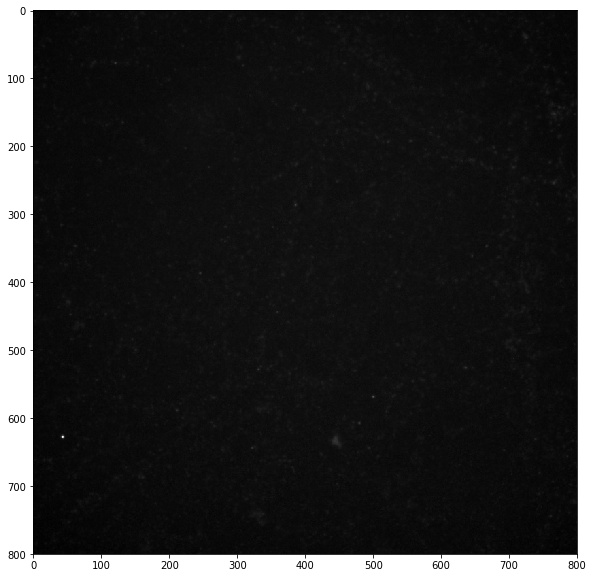

In [24]:
print(raw[channels.index('Bassoon')].shape)
plt.figure(figsize=(10,10))
plt.imshow(raw[channels.index('Bassoon')],cmap='gray')

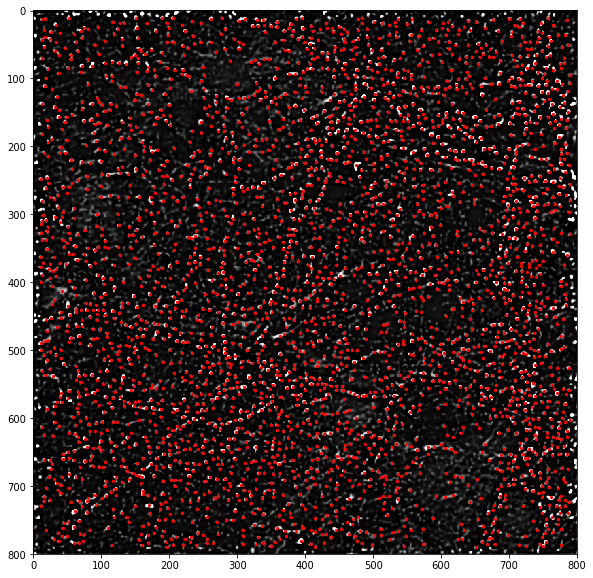

In [15]:
plt.figure(figsize=(10,10))
plt.imshow(y[0,0],cmap='gray')
xx,yy,_ = dognet.find_peaks(y[0,0],3)
plt.scatter(yy,xx,s=5,c='red')

Apply DoGNet

In [25]:
#Pack as the network was trained
import csv

def process(path,func=extract_main,draw=False):
    raw = imread(path)
    norm_raw = normalize(raw,get_normparams(raw))

    data = np.concatenate([np.expand_dims(norm_raw[channels.index(s)],0) for s in req_channels])
    y = inference(net,data)
    xx,yy,_ = dognet.find_peaks(y[0,0],3)
    pic= (data-data.min())/(data.max()-data.min()) 
    if draw:
        plt.figure(figsize=(20,20))
        plt.imshow(pic.transpose(1,2,0))
        plt.scatter(yy,xx,s=5,c='red')
        
    desc = []
    #x,y,amp,ax1_width,ax2_width,stdxy, angle_rad, y, x
    #2,3,4,5
    #A,stdx2,stdy2,stdxy
    fields = ["X","Y"]
    for pr in proteins:        
        index = channels.index(pr)
        dsc,base = func(raw[index],xx,yy)
        desc+=[dsc]
        fields+=[b.format(pr) for b in base]
    results = np.concatenate([np.array([xx,yy]).T,np.concatenate(desc,1)],1)
    
   
    ofile  = open(path[:-3]+"csv", "wb")
    writer = csv.writer(ofile, delimiter=',', quotechar=' ', quoting=csv.QUOTE_ALL)

    writer.writerow(fields)
    writer.writerows(results.tolist())

    ofile.close()
    
import os
basepath = "/media/hpc-4_Raid/vkulikov/MIT"
images = [os.path.join(basepath,f) for f in os.listdir(basepath) if f.endswith("tif")]
for im in images:
    print(im)
    process(im)

/media/hpc-4_Raid/vkulikov/MIT/r07c03f02.tif
/media/hpc-4_Raid/vkulikov/MIT/r05c03f04.tif
/media/hpc-4_Raid/vkulikov/MIT/r07c03f03.tif
/media/hpc-4_Raid/vkulikov/MIT/r02c03f01.tif
/media/hpc-4_Raid/vkulikov/MIT/r04c03f04.tif
/media/hpc-4_Raid/vkulikov/MIT/r05c03f02.tif
/media/hpc-4_Raid/vkulikov/MIT/r04c03f02.tif
/media/hpc-4_Raid/vkulikov/MIT/r06c03f02.tif
/media/hpc-4_Raid/vkulikov/MIT/r03c03f02.tif
/media/hpc-4_Raid/vkulikov/MIT/r03c03f04.tif
/media/hpc-4_Raid/vkulikov/MIT/r02c03f03.tif
/media/hpc-4_Raid/vkulikov/MIT/r02c03f04.tif
/media/hpc-4_Raid/vkulikov/MIT/r07c03f01.tif
/media/hpc-4_Raid/vkulikov/MIT/r07c03f04.tif
/media/hpc-4_Raid/vkulikov/MIT/r05c03f01.tif
/media/hpc-4_Raid/vkulikov/MIT/r04c03f05.tif
/media/hpc-4_Raid/vkulikov/MIT/r05c03f05.tif
/media/hpc-4_Raid/vkulikov/MIT/r02c03f05.tif
/media/hpc-4_Raid/vkulikov/MIT/r03c03f05.tif
/media/hpc-4_Raid/vkulikov/MIT/r02c03f02.tif
/media/hpc-4_Raid/vkulikov/MIT/r04c03f01.tif
/media/hpc-4_Raid/vkulikov/MIT/r07c03f05.tif
/media/hpc